In [1]:
!pip install keras-vggface==0.5

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 14.8 MB 898 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.5-py3-none-any.whl size=7238 sha256=cf71053b0e55d41908a30c704b0287e2b305bf6adfaccc7665b44035a8fb090c
  Stored in directory: /root/.cache/pip/wheels/14/80/4d/0c6b9c5d457c9f5b2c4dbff1d5d02a12ed9106240acb447f08
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77048 sha256=d59551dd248c04edaaca70e1513af16457f674d224909e76ca289704764fd6f2
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built keras-vggface wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.

In [5]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 759 kB/s            


In [2]:
filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('from keras.applications.imagenet_utils import _obtain_input_shape', 'from keras_applications.imagenet_utils import _obtain_input_shape'))

20756

In [3]:
filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20757

In [6]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow
from sklearn import metrics
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [8]:
base_path = "../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"
batch_size=64
image_gen =  ImageDataGenerator(
        rescale = 1./255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)


train_flow= image_gen.flow_from_directory(
    base_path + 'train/',
    target_size = (224, 224),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode ='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size = (224, 224),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode = 'binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size = (224, 224),
    batch_size = 1,
    shuffle = False,
    #color_mode='grayscale',
    class_mode ='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [9]:
vgg_model = VGGFace(include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('pool5').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(2048, activation='relu', name='fc1')(flat_layer)
dense2 = Dense(1, activation='sigmoid', name='dense2')(fc1)

custom_vgg_model = Model(vgg_model.input, dense2)

2022-01-29 06:00:01.488589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 06:00:01.586124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 06:00:01.586889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 06:00:01.588377: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58925056/58909280 [==============================] - 4s 0us/step


In [10]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0002)
custom_vgg_model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
from keras.callbacks import ModelCheckpoint
filepath = "saved-final-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [12]:
train_steps = 100000//100
valid_steps = 20000//100

history = custom_vgg_model.fit_generator(
    train_flow,
    epochs =10,
    callbacks= callbacks_list,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-01-29 06:00:09.654381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-29 06:00:12.685899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 1509s 1s/step - loss: 0.2903 - accuracy: 0.8739 - val_loss: 0.1664 - val_accuracy: 0.9340

Epoch 00001: val_accuracy improved from -inf to 0.93398, saving model to saved-final-model.h5
Epoch 2/10
1000/1000 [==============================] - 1242s 1s/step - loss: 0.1359 - accuracy: 0.9476 - val_loss: 0.1030 - val_accuracy: 0.9620

Epoch 00002: val_accuracy improved from 0.93398 to 0.96195, saving model to saved-final-model.h5
Epoch 3/10
1000/1000 [==============================] - 1140s 1s/step - loss: 0.0969 - accuracy: 0.9641 - val_loss: 0.1242 - val_accuracy: 0.9511

Epoch 00003: val_accuracy did not improve from 0.96195
Epoch 4/10
1000/1000 [==============================] - 1102s 1s/step - loss: 0.0769 - accuracy: 0.9711 - val_loss: 0.0795 - val_accuracy: 0.9712

Epoch 00004: val_accuracy improved from 0.96195 to 0.97125, saving model to saved-final-model.h5
Epoch 5/10
1000/1000 [==============================] - 1100s 1s/step - loss: 0.

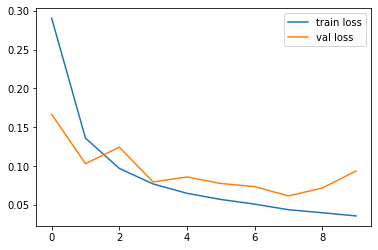

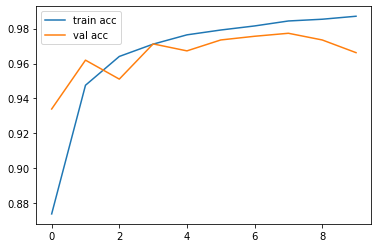

In [13]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
y_pred = custom_vgg_model.predict(test_flow)
y_test = test_flow.classes

In [15]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9981797299999999
AP Score: 0.9981013413821029

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.99      0.93      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.96      0.96     20000



In [16]:
y_test1 = np.array(y_test)
y_test1

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [17]:
y_pred1 = y_pred.copy()
np.where(y_pred1 > 0.5, 1, 0)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [18]:
y_pred2 = y_pred1.flatten()
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[9951   49]
 [ 659 9341]]
acc: 0.9646
sensitivity: 0.9951
specificity: 0.9341


<AxesSubplot:>

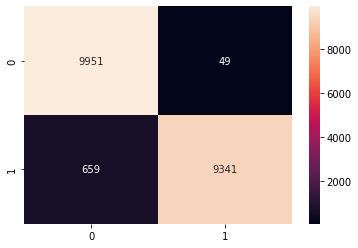

In [20]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')